#ConTextTransformer

This is a demo notebook for a simple multi-modal Transformer model that has been pre-trained on the ConText dataset.

The [Con-Text dataset](https://staff.fnwi.uva.nl/s.karaoglu/datasetWeb/Dataset.html) is built from two sub-categories of the ImageNet dataset: "building" and "place of business". The task is fine-grained classification. The dataset consists of 28 categories (e.g. "Bakery", "Bistro", "Restaurant", "Cafe", "Pizzeria", etc.) with 24,255 images in total.

Using scene text (when available) provides high-level semantic information that is useful for the task. However, not all the images have text in them. Moreover, high variability of text size, location, resolution and style and, uncontrolled environmental settings ( illumination ) make text recognition from this dataset harder.

In this ConTextTransformer demo we first use three pre-trained models for feature extraction: a ResNet50, an OCR, and the FastText word embedding. Then we project the visual (ResNet) and textual (FastText) features to a common dimensionality (Linear Projections) and we feed them into the Tansformer Encoder. Finally, the MLP head takes the output feature of the CLS token and predicts one of the classes with Softmax.

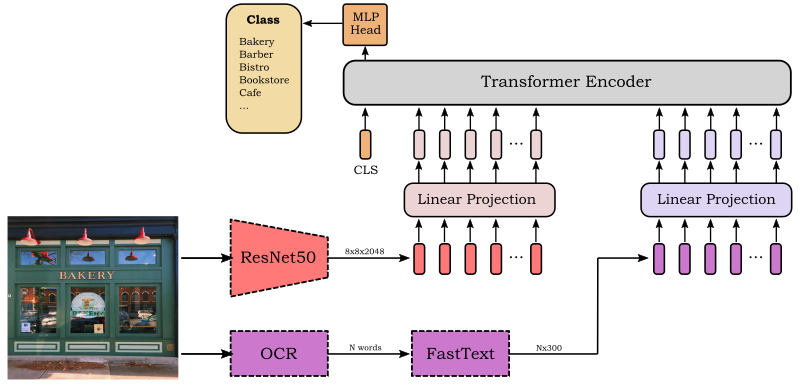

Let's start by installing and importing the necessary Python modules.

In [1]:
!pip install einops
!pip install fasttext-wheel
!pip install fasttext

# for the OCR module (see below)
!pip install opencv-python-headless==4.1.2.30
!pip install easyocr

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  ERROR: Command errored out with exit status 1:
   command: /anaconda/envs/azureml_py38_PT_and_TF/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-oy1tzgk6/fasttext/setup.py'"'"'; __file__='"'"'/tmp/pip-install-oy1tzgk6/fasttext/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-bishaq0x
       cwd: /tmp/pip-install-oy1tzgk6/fasttext/
  Complete output (56 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.8
  creating build/lib.linux-x86_64-3.8/fasttext
  copying python/fasttext_module/fasttext/__init__.py -> build/lib.linux-x86_64-3.8/fasttext
  copying python/fasttext_module/fasttext/FastText.py -> build/lib.linux-x86_64-3.8/fasttext
  creating build/lib.linux-x86_64-3.8/fasttext/ut

In [1]:
from PIL import Image
import numpy as np
import easyocr

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import Dataset

from einops import rearrange

import fasttext
import fasttext.util

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\Vali\AppData\Roaming\Python\Python312\site-packages\torch\lib\shm.dll" or one of its dependencies.

We must download the pre-trained FastText model and load it into memory. Unfortunately this takes around 20 minutes in Colab. 

In [3]:
fasttext.util.download_model('en', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('cc.en.300.bin')

## Define and create the model

Here we define the architecture of our model. See the comments in the code for better understanding. 

For the Transformer Encoder we use the built-in [PyTorch Transformer Layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

In [4]:
class ConTextTransformer(nn.Module):
    def __init__(self, *, image_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()

        # Visual feature extractor
        resnet50 = torchvision.models.resnet50(pretrained=True)
        modules=list(resnet50.children())[:-2]
        self.resnet50=nn.Sequential(*modules)
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.num_cnn_features = 64  # 8x8
        self.dim_cnn_features = 2048
        self.dim_fasttext_features = 300

        # Embeddings for the visual and textual features
        self.cnn_feature_to_embedding = nn.Linear(self.dim_cnn_features, dim)
        self.fasttext_feature_to_embedding = nn.Linear(self.dim_fasttext_features, dim)

        # Learnable position embeddings (for the visual features) and CLS token
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_cnn_features + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # The Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        encoder_norm = nn.LayerNorm(dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification Head (MLP)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, txt, mask=None):
        x = self.resnet50(img)
        x = rearrange(x, 'b d h w -> b (h w) d') # this makes a sequence of 64 videual features
        x = self.cnn_feature_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        x2 = self.fasttext_feature_to_embedding(txt.float())
        x = torch.cat((x,x2), dim=1)
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

Now we can create our model and load the pre-trained weights. 

The particular model instance we use in this demo has only **two encoder layers with 4 heads**, the dimensions of embeddings and encoder linear layers are 256 and 512 respectively.

In [1]:
#luiz gomez
model = ConTextTransformer(image_size=256, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)

!wget https://raw.githubusercontent.com/lluisgomez/ConTextTransformer/main/all_best.pth

model.load_state_dict(torch.load('all_best.pth'))
model.to(device)
model.eval()

NameError: name 'ConTextTransformer' is not defined

In [5]:
#modelul nostru

model = ConTextTransformer(image_size=256, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)

model.load_state_dict(torch.load('our_all_best.pth'))
model.to(device)
model.eval()

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConTextTransformer(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

Here we define the image transformations, the class labels dictionary, and the inference method.

In [6]:
img_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(256),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class_labels = {1: "Bakery", 2: "Barber", 3: "Bistro", 4: "Bookstore", 5: "Cafe", 6: "ComputerStore", 7: "CountryStore", 8: "Diner", 9: "DiscounHouse", 10: "Dry Cleaner", 11: "Funeral", 12: "Hotspot", 13: "MassageCenter", 14: "MedicalCenter", 15: "PackingStore", 16: "PawnShop", 17: "PetShop", 18: "Pharmacy", 19: "Pizzeria", 20: "RepairShop", 21: "Restaurant", 22: "School", 23: "SteakHouse", 24: "Tavern", 25: "TeaHouse", 26: "Theatre", 27: "Tobacco", 28: "Motel"}

def context_inference(img_filename, OCR_tokens):
  img = Image.open(img_filename).convert('RGB')
  img = img_transforms(img)
  img = torch.unsqueeze(img, 0)
  
  text = np.zeros((1, 64, 300))
  for i,w in enumerate(OCR_tokens):
    text[0,i,:] = fasttext_model.get_word_vector(w)

  output = F.softmax(model(img.to(device), torch.tensor(text).to(device)), dim=1)
  return output.cpu().detach().numpy()

## ConText inference demo

We have everything ready to do some inference experiments with the pre-trained model. Let's start by downloading one image for testing.

In [2]:
#!wget -q https://gailsbread.co.uk/wp-content/uploads/2017/11/Summertown-1080x675.jpg

from IPython.display import Image as ShowImage
ShowImage('Summertown-1080x675.jpg')

'wget' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: No such file or directory: 'z75dwkR'

FileNotFoundError: No such file or directory: 'z75dwkR'

<IPython.core.display.Image object>

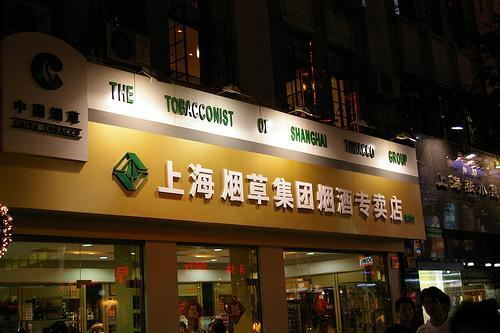

In [25]:
testImage = 'images/data/JPEGImages/n04443257_18603.jpg'
ShowImage(testImage)

Now lets see how our model classifies the image depending if we use some textual information or not. For the moment we simulate the OCR output with a hard-coded list of words (*OCR_tokens*).

In [8]:
OCR_tokens = [] # Let's imagine our OCR model does not recognize any text

probs = context_inference('Summertown-1080x675.jpg', OCR_tokens)
class_id = np.argmax(probs)
print('Prediction without text: {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))


OCR_tokens = ['GAIL', 'ARTISAN', 'BAKERY'] # Simulate a perfect OCR output

probs = context_inference('Summertown-1080x675.jpg', OCR_tokens)
class_id = np.argmax(probs)
print('Prediction with text:\t {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))

Prediction without text: Restaurant (0.44556719064712524)
Prediction with text:	 Bakery (0.989266037940979)


In [26]:
OCR_tokens = [] # Let's imagine our OCR model does not recognize any text

probs = context_inference(testImage, OCR_tokens)
class_id = np.argmax(probs)
print('Prediction without text: {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))


OCR_tokens = ['GAIL', 'ARTISAN', 'BAKERY'] # Simulate a perfect OCR output

probs = context_inference(testImage, OCR_tokens)
class_id = np.argmax(probs)
print('Prediction with text:\t {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))

Prediction without text: Bookstore (0.295876145362854)
Prediction with text:	 Bakery (0.9986326098442078)


Now we can play a bit with the model ... try different images, contraste the predictions when using different words as OCR tokens, simulate OCR errors, etc.

In [9]:
# add your code here ... 

## Adding the OCR module for a fully functional system

There are different options for integrating a pre-trained OCR module. 

A typical photo-OCR pipeline would require two pre-trained models: one for text detection (e.g. [EAST](https://github.com/ZER-0-NE/EAST-Detector-for-text-detection-using-OpenCV) or [CRAFT](https://github.com/clovaai/CRAFT-pytorch)) and another for text recognition (e.g. from the [CLOVA recognition repo](https://github.com/clovaai/deep-text-recognition-benchmark)). An alternative is to use an end-to-end model that performs both detection and recognition (e.g. [MaskTextSpotterV3](https://github.com/MhLiao/MaskTextSpotterV3)).

All the models' repositories linked above have publicly available pre-trained weigths and code that one can integrate in a fully functional multi-modal system. However they require some installation steps and "glue" code that is not very practical for a notebook. For this reason we are going to use here a simpler alternative based on open source solution: the [EasyOCR](https://github.com/JaidedAI/EasyOCR) Python package. It is a cool project that aims at making state of the art text detection and recognition models quickly accessible to the public for free.

In [9]:
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['en']) # English text recognition model

In [10]:
def detect_text(img_filename):
    """Detects text in the image using EasyOCR"""
    results = reader.readtext(img_filename)
   
    words, boxes, confs = [], [], []
    for res in results:
        boxes.append(res[0])
        words.append(res[1])
        confs.append(res[2])
        
    return words, boxes, confs

Switch to PyTesseract OCR instead of using EasyOCR

In [16]:
!pip install pytesseract Pillow


In [23]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
from PIL import Image

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

def preprocess_image(img_filename):
    """Preprocess the image to improve OCR accuracy"""
    img = Image.open(img_filename)
    img = img.convert('L')  # Convert to grayscale
    img = img.filter(ImageFilter.MedianFilter())  # Apply median filter
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2)  # Enhance contrast
    return img

def detect_text(img_filename):
    """Detects text in the image using Tesseract OCR"""
    try:
        img = preprocess_image(img_filename)
        custom_config = r'--oem 3 --psm 6'  # Adjust these values as needed
        results = pytesseract.image_to_data(img, config=custom_config, output_type=pytesseract.Output.DICT)
       
        words, boxes, confs = [], [], []
        n_boxes = len(results['level'])
        for i in range(n_boxes):
            if int(results['conf'][i]) > 0:  # Filter out results with negative confidence
                (x, y, w, h) = (results['left'][i], results['top'][i], results['width'][i], results['height'][i])
                boxes.append(((x, y), (x + w, y + h)))
                words.append(results['text'][i])
                confs.append(float(results['conf'][i]))
        
        return words, boxes, confs
    except Exception as e:
        print(f"Error during OCR: {e}")
        return [], [], []



Now we can directly call our model using the output of the OCR API as our *OCR_tokens*.

In [24]:
img_filename = 'Summertown-1080x675.jpg'
OCR_tokens,_,_ = detect_text(img_filename)
probs = context_inference(img_filename, OCR_tokens)
class_id = np.argmax(probs)
print('Detected text: {}'.format(OCR_tokens))
print('Prediction: {} ({})'.format(class_labels[class_id+1], probs[0,class_id]))

Detected text: ['pi']
Prediction: Restaurant (0.36485132575035095)
